In [39]:
import numpy as np
import matplotlib.pyplot as plt
from bresenham import bresenham
import imageio
import pydicom
from pydicom.data import get_testdata_files

In [29]:
alfa = 1
n = 250
l = 90

In [30]:
"""
Obliczanie współrzędnych (x, y) i-tego z n emiterów na okręgu o promieniu r i rozpiętości l. 
Pamiętaj o tym, że środek okręgu jest środkiem obrazu (offset)
W przypadku układu z jednym emiterem, funkcja powinna być niezależna od i oraz n
Pamiętaj o ewentualnej konwersji stopnie -> radiany
http://www.cs.put.poznan.pl/swilk/pmwiki/uploads/Dydaktyka/tomograf-wzory.pdf
"""
def emiterPosition(angle, i, n, r, l, offset):
    x = r * np.cos( np.radians(angle) ) + offset[0]
    y = r * np.sin( np.radians(angle) ) + offset[1]
    return (x,y)

In [31]:
"""
Obliczanie współrzędnych (x, y) i-tego z n sensorów na okręgu o promieniu r i rozpiętości l.
Pamiętaj o tym, że środek okręgu jest środkiem obrazu (offset)
http://www.cs.put.poznan.pl/swilk/pmwiki/uploads/Dydaktyka/tomograf-wzory.pdf
"""
def sensorPosition(angle, i, n, r, l, offset):
    x = r * np.cos( np.radians(angle) + np.pi - np.radians(l)/2 + i * ( np.radians(l) / (n-1) ) ) + offset[0]
    y = r * np.sin( np.radians(angle) + np.pi - np.radians(l)/2 + i * ( np.radians(l) / (n-1) ) ) + offset[1]
    return (x,y)

In [32]:
"""
Symulacja laseru przechodzącego liniowo przez obraz image z punktu start do punktu end.
Należy policzyć, ile mocy lasera zostanie pochłonięte, skorzystaj z funkcji bresenham
"""
def beam(image, start, end):
    width, height = image.shape
    x = bresenham(int(start[0]), int(start[1]), int(end[0]), int(end[1]))
    y = np.array(list(x))
    y = y[y[:,0] >= 0]
    y = y[y[:,0] < width]
    y = y[y[:,1] >= 0]
    y = y[y[:,1] < height]
    return np.sum(image[y[:,0],y[:,1]])

In [33]:
def makeGif(gif, filename):
    scale = gif[-1].max()
    gif = list(map(lambda x: (x/scale*255).astype(np.uint8), gif))
    imageio.mimsave(filename+".gif", gif)

In [34]:
def radon_iwm(img_gray, alfa, n, l, R):   
    gif = []
    result = np.zeros((n, len(np.arange(-90,90,alfa))))
    for i,angle in enumerate(np.arange(-90,90,alfa)[::-1]):
        result[..., i] = np.array([beam(img_gray, 
                                         emiterPosition(angle, sensor, n, R, l, (img_gray.shape[1]/2, img_gray.shape[0]/2)),
                                         sensorPosition(angle, sensor, n, R, l, (img_gray.shape[1]/2, img_gray.shape[0]/2)))
                                   for sensor in range(n)])
        
        if angle % 10 == 0:
            print(f"angle {angle}")
        gif.append(result.copy())
    makeGif(gif, "radon")
    return result/result.max()

In [35]:
def radon_iwm2(img_gray, alfa, n, l, R):   
    result = np.zeros((n, len(np.arange(-90,90,alfa))))
    for i,angle in enumerate(np.arange(-90,90,alfa)[::-1]):
        y = [(emiterPosition(angle, sensor, n, R, l, (img_gray.shape[1]/2, img_gray.shape[0]/2)),
                                         sensorPosition(angle, sensor, n, R, l, (img_gray.shape[1]/2, img_gray.shape[0]/2)))
                                   for sensor in range(n)]
        plt.imshow(img_gray)
        #y = np.array(y)
        #x = y[:,0]
        #y = y[:,1]
        #plt.plot(x[:,0], x[:,1], "*")
        #plt.plot(y[:,0], y[:,1], ".")
        #plt.show()
        #if angle % 10 == 0:
            #print(f"angle {angle}")
        
    
    return 0

In [36]:
def inverseRadon_iwn(radon, shape, alfa, n, l, R):
    width, height = shape
    gif = []
    result = np.zeros(shape)
    R = max(shape)*2**.5+10
    for i, angle in enumerate(np.arange(-90,90,alfa)[::-1]):
        for sensor in range(n):
            start = emiterPosition(angle, sensor, n, R, l, (shape[1]/2, shape[0]/2))
            end = sensorPosition(angle, sensor, n, R, l, (shape[1]/2, shape[0]/2))
            """
            Wykorzystaj algorythm Bresenhama, aby znaleźć współrzędne pikseli na obrazie.
            Uwzględnij na tych pozycjach wartość, która została zwrócona kiedy laser przechodził przez obraz
            """
            x = bresenham(int(start[0]), int(start[1]), int(end[0]), int(end[1]))
            y = np.array(list(x))
            y = y[y[:,0] >= 0]
            y = y[y[:,0] < width]
            y = y[y[:,1] >= 0]
            y = y[y[:,1] < height]
            
            
            result[y[:,0], y[:,1]] += radon[sensor][i]
        
        if angle % 10 == 0:
            print(f"angle {angle}")
        gif.append(result.copy())
    makeGif(gif, "inverse")
    return result/result.max()

In [40]:
def projekt1(file, alfa, n, l):
    img = plt.imread(file)
    img_gray = img[...,0]
    print(img_gray)
    plt.imshow(img_gray)
    print(f"imgshape {img_gray.shape}")
    R = (max(img_gray.shape)/2)*2**.5+10 
    radon = radon_iwm(img_gray, alfa, n, l, R)
    plt.imshow(radon, cmap=plt.cm.bone)
    plt.show()
    iradon = inverseRadon_iwn(radon, img_gray.shape, alfa, n, l, R)
    print(iradon)
    plt.imshow(iradon, cmap=plt.cm.bone)
    plt.show()
    return iradon

In [ ]:
def load_scan(path):
    slices = [pydicom.dcmread(path + ‘/’ + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if ‘SliceLocation’ in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] —   
                          slices[1].ImagePositionPatient[2])
    except:
    slice_thickness = np.abs(slices[0].SliceLocation — 
                      slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [41]:
filename = "example.dicom"
patient_name = "Jan"
patient_surname = "Kowalski"
study_date = "20040119"
comments = "Pacjent przezyl"

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
imgshape (1024, 1024)
angle 80
angle 70
angle 60
angle 50
angle 40
angle 30
angle 20
angle 10
angle 0
angle -10
angle -20
angle -30
angle -40
angle -50
angle -60
angle -70
angle -80
angle -90


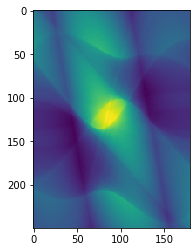

angle 80
angle 70
angle 60
angle 50
angle 40
angle 30
angle 20


In [ ]:

#dataset = pydicom.dcmread(filename)
projekt1("Shepp_logan.jpg", alfa, n, l)